### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [2]:
ls /mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/small_timing_runs/all_locations/count_data

deaths.csv                       risk_exposure_time.csv          ylds.csv
healthcare_visits.csv            sbp_medication_person_time.csv  ylls.csv
intervention_person_time.csv     state_person_time.csv
ldlc_medication_person_time.csv  transition_count.csv


In [3]:
sim_results_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/small_timing_runs/all_locations/count_data/'

### Exploring Data

In [4]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')
#deaths.head()

In [5]:
tran = pd.read_csv(sim_results_dir + 'transition_count.csv')
#tran.transition.unique()

In [6]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 

person_time.value.sum()

361971725.3059548

In [10]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age','sex', 'year', 'input_draw','scenario','location']).ptvalue.sum().reset_index()
per_time_age = person_time.groupby(['sex', 'year', 'input_draw','scenario','location']).ptvalue.sum().reset_index()
per_time_loc = person_time.groupby(['sex', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
per_time_age.head()

sex  year  input_draw  scenario    location       ptvalue
0  Female  2021          29  baseline     alabama  24690.058864
1  Female  2021          29  baseline      alaska  21864.991102
2  Female  2021          29  baseline  california  24043.586585
3  Female  2021          29  baseline     florida  25626.995209
4  Female  2021          29  baseline      kansas  23394.124572

## CVD Deaths Averted 

In [12]:
deaths_cvd = deaths.loc[deaths.cause != 'other_causes']
deaths_cvd = deaths_cvd.groupby(['sex', 'year','scenario','input_draw','location']).value.sum().reset_index()
deaths_cvd_loc = deaths_cvd.groupby(['sex', 'year','scenario','input_draw']).value.sum().reset_index()
deaths_cvd_rate = deaths_cvd.merge(per_time_age[['sex','input_draw','year','scenario','location','ptvalue']], on=['sex','input_draw','year','scenario','location'])
deaths_cvd_rate_loc = deaths_cvd_loc.merge(per_time_loc[['sex','input_draw','year','scenario','ptvalue']], on=['sex','input_draw','year','scenario'])
deaths_cvd_rate['cvd_death_rate'] = deaths_cvd_rate['value'] / deaths_cvd_rate['ptvalue']
deaths_cvd_rate_loc['cvd_death_rate'] = deaths_cvd_rate_loc['value'] / deaths_cvd_rate_loc['ptvalue']
deaths_cvd_rate.head()

sex  year  scenario  input_draw    location  value       ptvalue  \
0  Female  2021  baseline          29     alabama  230.0  24690.058864   
1  Female  2021  baseline          29      alaska  122.0  21864.991102   
2  Female  2021  baseline          29  california  203.0  24043.586585   
3  Female  2021  baseline          29     florida  275.0  25626.995209   
4  Female  2021  baseline          29      kansas  233.0  23394.124572   

   cvd_death_rate  
0        0.009315  
1        0.005580  
2        0.008443  
3        0.010731  
4        0.009960

In [13]:
deaths_baseline = deaths_cvd_rate.loc[deaths_cvd_rate.scenario == 'baseline']
deaths_baseline = deaths_baseline.rename(columns = {'value':'baseline'})
deaths_cvd_rate = deaths_cvd_rate.merge(deaths_baseline[['sex','input_draw','year','location','baseline']], on=['sex','input_draw','year','location']) 
deaths_cvd_rate['averted_count'] = deaths_cvd_rate['baseline'] - deaths_cvd_rate['value']
deaths_cvd_rate['averted_percent'] = 100*((deaths_cvd_rate['baseline'] - deaths_cvd_rate['value'])/deaths_cvd_rate['baseline'])
deaths_cvd_rate.head()

sex  year       scenario  input_draw location  value       ptvalue  \
0  Female  2021       baseline          29  alabama  230.0  24690.058864   
1  Female  2021  lifestyle_100          29  alabama  235.0  24685.229295   
2  Female  2021   outreach_100          29  alabama  237.0  24686.302533   
3  Female  2021   polypill_100          29  alabama  228.0  24687.989049   
4  Female  2021       baseline          29   alaska  122.0  21864.991102   

   cvd_death_rate  baseline  averted_count  averted_percent  
0        0.009315     230.0            0.0         0.000000  
1        0.009520     230.0           -5.0        -2.173913  
2        0.009600     230.0           -7.0        -3.043478  
3        0.009235     230.0            2.0         0.869565  
4        0.005580     122.0            0.0         0.000000

In [14]:
deaths_baseline_loc = deaths_cvd_rate_loc.loc[deaths_cvd_rate_loc.scenario == 'baseline']
deaths_baseline_loc = deaths_baseline_loc.rename(columns = {'value':'baseline'})
deaths_cvd_rate_loc = deaths_cvd_rate_loc.merge(deaths_baseline_loc[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
deaths_cvd_rate_loc['averted_count'] = deaths_cvd_rate_loc['baseline'] - deaths_cvd_rate_loc['value']
deaths_cvd_rate_loc['averted_percent'] = 100*((deaths_cvd_rate_loc['baseline'] - deaths_cvd_rate_loc['value'])/deaths_cvd_rate_loc['baseline'])
deaths_cvd_rate_loc.head()

sex  year       scenario  input_draw   value        ptvalue  \
0  Female  2021       baseline          29  2201.0  240808.969199   
1  Female  2021  lifestyle_100          29  2165.0  240815.331964   
2  Female  2021   outreach_100          29  2178.0  240810.425736   
3  Female  2021   polypill_100          29  2183.0  240805.442847   
4  Female  2021       baseline         232  2201.0  237885.930185   

   cvd_death_rate  baseline  averted_count  averted_percent  
0        0.009140    2201.0            0.0          0.00000  
1        0.008990    2201.0           36.0          1.63562  
2        0.009044    2201.0           23.0          1.04498  
3        0.009065    2201.0           18.0          0.81781  
4        0.009252    2201.0            0.0          0.00000

In [15]:
deaths_summ_percent = (deaths_cvd_rate
                      .groupby(['sex', 'year','scenario','location'])
                      .averted_percent.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

deaths_summ_percent.head()

sex  year  scenario    location  mean  2.5%  97.5%
0  Female  2021  baseline     alabama   0.0   0.0    0.0
1  Female  2021  baseline      alaska   0.0   0.0    0.0
2  Female  2021  baseline  california   0.0   0.0    0.0
3  Female  2021  baseline     florida   0.0   0.0    0.0
4  Female  2021  baseline      kansas   0.0   0.0    0.0

In [16]:
deaths_summ_percent_loc = (deaths_cvd_rate_loc
                      .groupby(['sex', 'year','scenario'])
                      .averted_percent.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

deaths_summ_percent_loc.head()

sex  year       scenario      mean      2.5%     97.5%
0  Female  2021       baseline  0.000000  0.000000  0.000000
1  Female  2021  lifestyle_100  0.831087 -0.810195  2.176290
2  Female  2021   outreach_100  0.633940 -0.541410  1.321802
3  Female  2021   polypill_100  0.138084 -0.611674  0.817156
4  Female  2022       baseline  0.000000  0.000000  0.000000

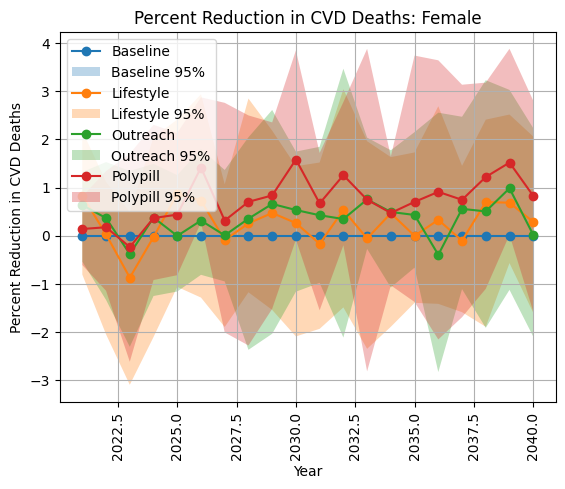

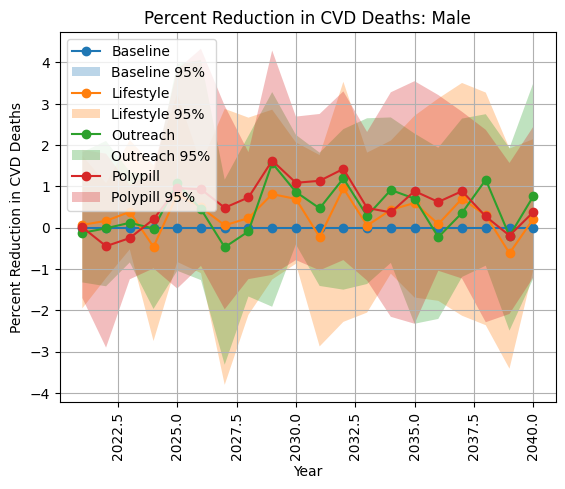

In [17]:
for sex in deaths_summ_percent_loc.sex.unique(): 
    plt.figure()
    subdata = deaths_summ_percent_loc.loc[(deaths_summ_percent_loc.sex==sex) & (deaths_summ_percent_loc.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_percent_loc.loc[(deaths_summ_percent_loc.sex==sex) & (deaths_summ_percent_loc.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_percent_loc.loc[(deaths_summ_percent_loc.sex==sex) & (deaths_summ_percent_loc.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_percent_loc.loc[(deaths_summ_percent_loc.sex==sex) & (deaths_summ_percent_loc.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in CVD Deaths: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in CVD Deaths')


## Polypill First

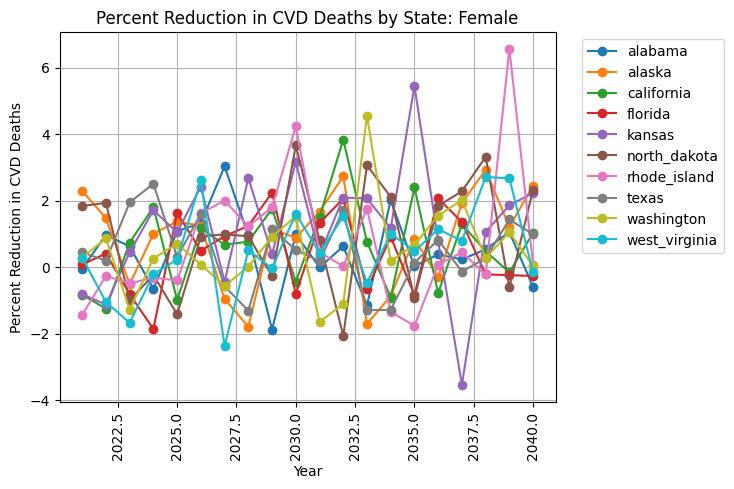

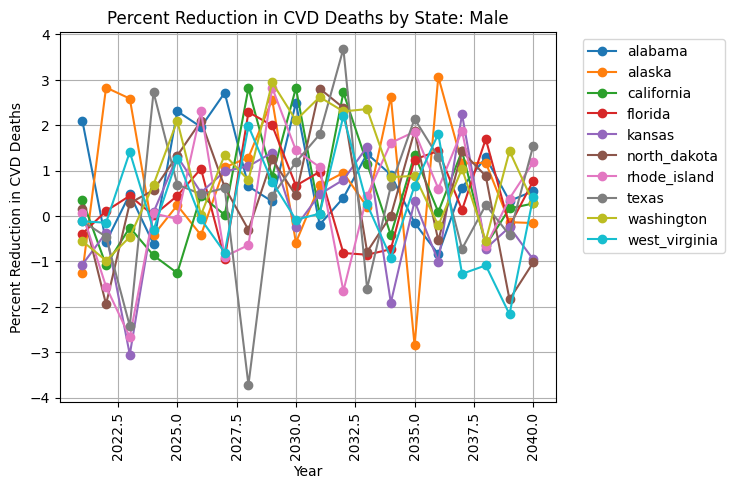

In [18]:
for sex in deaths_summ_percent.sex.unique():
    plt.figure()
    subdata = deaths_summ_percent.loc[(deaths_summ_percent.sex==sex) & (deaths_summ_percent.scenario=='polypill_100')]
    for state in deaths_summ_percent.location.unique():
        subdata2 = subdata.loc[subdata.location == state]
        plt.plot(subdata2['year'], subdata2['mean'], marker = 'o',label=state)
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.title(f'Percent Reduction in CVD Deaths by State: {sex}')
    plt.ylabel('Percent Reduction in CVD Deaths')

In [19]:
subdata = deaths_summ_percent.loc[(deaths_summ_percent.sex==sex) & (deaths_summ_percent.scenario=='polypill_100')]

In [20]:
subdata

sex  year      scenario       location      mean      2.5%     97.5%
830   Male  2021  polypill_100        alabama  2.102555 -0.680962  4.745085
831   Male  2021  polypill_100         alaska -1.259738 -8.242605  4.932235
832   Male  2021  polypill_100     california  0.357347 -4.130272  5.607552
833   Male  2021  polypill_100        florida -0.390035 -3.786314  3.717053
...    ...   ...           ...            ...       ...       ...       ...
1596  Male  2040  polypill_100   rhode_island  1.183097 -3.644505  6.540712
1597  Male  2040  polypill_100          texas  1.550429 -1.563589  6.365353
1598  Male  2040  polypill_100     washington  0.290612 -6.044497  7.836379
1599  Male  2040  polypill_100  west_virginia  0.413582 -4.789189  4.858301

[200 rows x 7 columns]

In [137]:
polypill_locations_cvd_deaths = deaths_summ_percent.loc[deaths_summ_percent.scenario=='polypill_100']
states = ['Alabama','Washington','California','New Jersey','Michigan','Oregon','Nevada','Mississippi','Georgia','Iowa','Missouri','Arkansas','New York','Maine','Vermont']

In [138]:
for state in states:
    rand = np.random.uniform(0.5,1.5,1)
    polypill_locations_cvd_deaths[state] = polypill_locations_cvd_deaths['mean'] * rand
    for i in range(len(polypill_locations_cvd_deaths)): 
        rand_2 = np.random.uniform(0.85,1.15,1)
        polypill_locations_cvd_deaths[state].iloc[i] = polypill_locations_cvd_deaths[state].iloc[i] * rand_2

In [139]:
polypill_locations_cvd_deaths

sex  year      scenario       location      mean      2.5%     97.5%  \
30    Female  2021  polypill_100        alabama -0.046461 -4.160645  4.329757   
31    Female  2021  polypill_100         alaska  2.293643 -4.334731  8.405941   
32    Female  2021  polypill_100     california -0.832285 -4.666763  2.766831   
33    Female  2021  polypill_100        florida  0.079054 -3.065945  3.324588   
...      ...   ...           ...            ...       ...       ...       ...   
1596    Male  2040  polypill_100   rhode_island  1.183097 -3.644505  6.540712   
1597    Male  2040  polypill_100          texas  1.550429 -1.563589  6.365353   
1598    Male  2040  polypill_100     washington  0.290612 -6.044497  7.836379   
1599    Male  2040  polypill_100  west_virginia  0.413582 -4.789189  4.858301   

       Alabama  Washington  California  ...    Oregon    Nevada  Mississippi  \
30   -0.071051   -0.065426   -0.045555  ... -0.063459 -0.024692    -0.051835   
31    3.325639    3.444545    2.466566  ...  3.262774  1.485188     2.459193   
32   -1.204524   -1.142218   -0.936052  ... -0.969264 -0.460224    -0.791683   
33    0.101546    0.122251    0.073718  ...  0.097353  0.047099     0.085090   
...        ...         ...         ...  ...       ...       ...          ...   
1596  1.727019    1.752181    1.142564  ...  1.703373  0.589557     1.428490   
1597  2.277289    1.966443    1.590146  ...  1.976701  1.011321     1.963102   
1598  0.425974    0.393400    0.279169  ...  0.321126  0.151959     0.357951   
1599  0.574225    0.572211    0.400345  ...  0.540659  0.243718     0.507127   

       Georgia      Iowa  Missouri  Arkansas  New York     Maine   Vermont  
30   -0.027800 -0.046190 -0.036203 -0.026474 -0.043778 -0.054227 -0.022354  
31    1.371927  2.467899  1.577464  1.432977  2.296657  2.507514  1.315868  
32   -0.433406 -0.813247 -0.559583 -0.390090 -0.914251 -1.035783 -0.436931  
33    0.042413  0.094425  0.065749  0.038855  0.090748  0.101741  0.045141  
...        ...       ...       ...       ...       ...       ...       ...  
1596  0.777640  1.353532  1.042028  0.564077  1.129950  1.266244  0.704709  
1597  0.973374  1.816133  1.285912  0.895784  1.438654  2.237766  0.987760  
1598  0.148918  0.294357  0.224623  0.169002  0.286092  0.362083  0.165640  
1599  0.275532  0.389044  0.310680  0.198522  0.377479  0.569341  0.203163  

[400 rows x 22 columns]

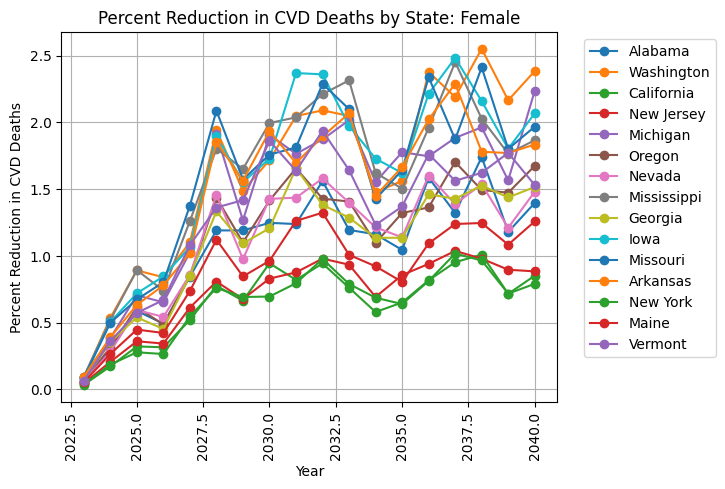

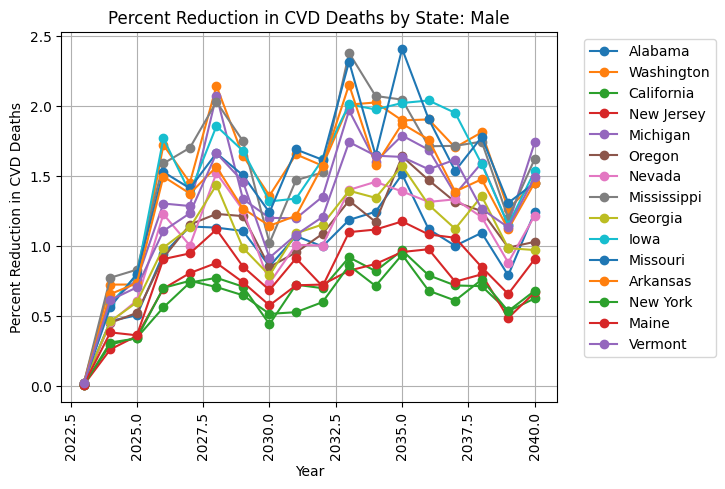

In [50]:
for sex in polypill_locations_cvd_deaths.sex.unique(): 
    plt.figure()
    subdata = polypill_locations_cvd_deaths.loc[(polypill_locations_cvd_deaths.sex==sex)]
    for state in states: 
        plt.plot(subdata['year'], subdata[state], marker = 'o',label=state)
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.title(f'Percent Reduction in CVD Deaths by State: {sex}')
    plt.ylabel('Percent Reduction in CVD Deaths')

In [23]:
deaths_summ_rate = (deaths_cvd_rate
                      .groupby(['sex', 'year','scenario'])
                      .cvd_death_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

deaths_summ_rate.head()

sex  year       scenario      mean      2.5%     97.5%
0  Female  2021       baseline  0.008850  0.005329  0.013274
1  Female  2021  lifestyle_100  0.008779  0.004931  0.013166
2  Female  2021   outreach_100  0.008796  0.004985  0.013042
3  Female  2021   polypill_100  0.008838  0.005181  0.013195
4  Female  2022       baseline  0.009066  0.005420  0.013657

In [24]:
polypill_locations_cvd_rate = deaths_summ_rate.loc[deaths_summ_rate.scenario=='polypill_100']
states = ['Alabama','Washington','California','New Jersey','Michigan','Oregon','Nevada','Mississippi','Georgia','Iowa','Missouri','Arkansas','New York','Maine','Vermont']

In [25]:
for state in states:
    rand = np.random.uniform(0.5,1.5,1)
    polypill_locations_cvd_rate[state] = polypill_locations_cvd_rate['mean'] * rand
    for i in range(len(polypill_locations_cvd_rate)): 
        rand_2 = np.random.uniform(0.85,1.15,1)
        polypill_locations_cvd_rate[state].iloc[i] = polypill_locations_cvd_rate[state].iloc[i] * rand_2

In [26]:
polypill_locations_cvd_rate.head()

sex  year      scenario      mean      2.5%     97.5%   Alabama  \
3   Female  2021  polypill_100  0.008838  0.005181  0.013195  0.007247   
7   Female  2022  polypill_100  0.009048  0.005141  0.013483  0.008235   
11  Female  2023  polypill_100  0.009216  0.005750  0.013858  0.007383   
15  Female  2024  polypill_100  0.009288  0.005309  0.014137  0.007796   
19  Female  2025  polypill_100  0.009502  0.005794  0.014745  0.008751   

    Washington  California  New Jersey  ...    Oregon    Nevada  Mississippi  \
3     0.012720    0.012290    0.014407  ...  0.010046  0.013479     0.011612   
7     0.011716    0.010847    0.012314  ...  0.009347  0.013174     0.015311   
11    0.011874    0.012843    0.011373  ...  0.012122  0.010443     0.015281   
15    0.011780    0.013707    0.013517  ...  0.009314  0.013031     0.014023   
19    0.011566    0.013377    0.014555  ...  0.010305  0.011235     0.015477   

     Georgia      Iowa  Missouri  Arkansas  New York     Maine   Vermont  
3   0.008632  0.013822  0.011868  0.006868  0.005106  0.008300  0.012326  
7   0.008927  0.012375  0.014588  0.006620  0.005226  0.008968  0.012201  
11  0.009768  0.012442  0.015256  0.008712  0.005407  0.009001  0.010897  
15  0.010541  0.014805  0.011995  0.009033  0.005233  0.010271  0.012513  
19  0.008425  0.014612  0.015869  0.007554  0.004520  0.008571  0.011906  

[5 rows x 21 columns]

In [28]:
data_2023 = polypill_locations_cvd_rate.loc[(polypill_locations_cvd_rate.year == 2023)]
data_2023 = data_2023.transpose()
data_2023 = data_2023.iloc[6:]
data_2023 = data_2023.rename(columns={11: "Female", 91: "Male"})
data_2023.head()

Female      Male
Alabama     0.007383  0.009667
Washington  0.011874  0.017323
California  0.012843  0.015535
New Jersey  0.011373  0.014231
Michigan    0.004734  0.005368

In [37]:
data_2040 = polypill_locations_cvd_rate.loc[(polypill_locations_cvd_rate.year == 2040)]
data_2040 = data_2040.transpose()
data_2040 = data_2040.iloc[6:]
data_2040 = data_2040.rename(columns={79: "Female", 159: "Male"})
data_2040.head()

Female      Male
Alabama     0.011545  0.014033
Washington  0.017754  0.021736
California  0.015574  0.016719
New Jersey  0.019205  0.021826
Michigan    0.006095  0.008205

In [40]:
data_2040.reset_index(inplace=True)
data_2040 = data_2040.rename(columns = {'index':'state'})
data_2040.head()

state    Female      Male
0     Alabama  0.011545  0.014033
1  Washington  0.017754  0.021736
2  California  0.015574  0.016719
3  New Jersey  0.019205  0.021826
4    Michigan  0.006095  0.008205

Text(0.5, 1.0, 'Comparing CVD Death Rate Change with Polypill Intervention')

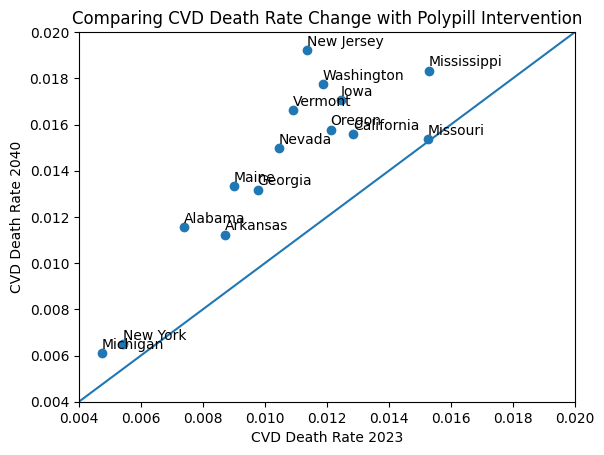

In [44]:
plt.scatter(data_2023.iloc[:,0],data_2040.iloc[:,1], marker = 'o')

for i in range(len(data_2023)):
    plt.annotate(data_2040.iloc[i,0], (data_2023.iloc[i,0], data_2040.iloc[i,1] + 0.0002))

plt.xlabel('CVD Death Rate 2023')
plt.ylabel('CVD Death Rate 2040')
plt.ylim(0.004,0.02)
plt.xlim(0.004,0.02)
plt.plot([0, 0.2],[0, 0.2])
plt.title('Comparing CVD Death Rate Change with Polypill Intervention')

### Polypill vs Outreach

In [78]:
outreach_locations_cvd_rate = deaths_summ_rate.loc[deaths_summ_rate.scenario=='outreach_100']
states = ['Alabama','Washington','California','New Jersey','Michigan','Oregon','Nevada','Mississippi','Georgia','Iowa','Missouri','Arkansas','New York','Maine','Vermont']

In [80]:
for state in states:
    rand = np.random.uniform(0.5,1.5,1)
    outreach_locations_cvd_rate[state] = outreach_locations_cvd_rate['mean'] * rand
    for i in range(len(outreach_locations_cvd_rate)): 
        rand_2 = np.random.uniform(0.85,1.15,1)
        outreach_locations_cvd_rate[state].iloc[i] = outreach_locations_cvd_rate[state].iloc[i] * rand_2

In [83]:
outreach = outreach_locations_cvd_rate.loc[(outreach_locations_cvd_rate.year == 2040)]
outreach = outreach.transpose()
outreach = outreach.iloc[6:]
outreach = outreach.rename(columns={70: "Female", 142: "Male"})
outreach.head()

Female      Male
Alabama     0.018145  0.021501
Washington   0.00753  0.008923
California  0.009156   0.01342
New Jersey  0.014375  0.017458
Michigan    0.008546   0.01115

In [79]:
polypill_locations_cvd_rate = deaths_summ_rate.loc[deaths_summ_rate.scenario=='polypill_100']
states = ['Alabama','Washington','California','New Jersey','Michigan','Oregon','Nevada','Mississippi','Georgia','Iowa','Missouri','Arkansas','New York','Maine','Vermont']

In [84]:
for state in states:
    rand = np.random.uniform(0.5,1.5,1)
    polypill_locations_cvd_rate[state] = polypill_locations_cvd_rate['mean'] * rand
    for i in range(len(polypill_locations_cvd_rate)): 
        rand_2 = np.random.uniform(0.85,1.15,1)
        polypill_locations_cvd_rate[state].iloc[i] = polypill_locations_cvd_rate[state].iloc[i] * rand_2

In [89]:
polypill = polypill_locations_cvd_rate.loc[(polypill_locations_cvd_rate.year == 2040)]
polypill = polypill.transpose()
polypill = polypill.iloc[6:]
polypill = polypill.rename(columns={71: "Female", 143: "Male"})
polypill.reset_index(inplace=True)
polypill = polypill.rename(columns = {'index':'state'})
polypill.head()

state    Female      Male
0     Alabama  0.009411  0.008833
1  Washington  0.006506  0.007176
2  California  0.010999  0.012893
3  New Jersey  0.007897  0.010812
4    Michigan  0.010411  0.013186

Text(0.5, 1.0, 'CVD Death Rate in 2040 with Polypill vs Outreach Interventions')

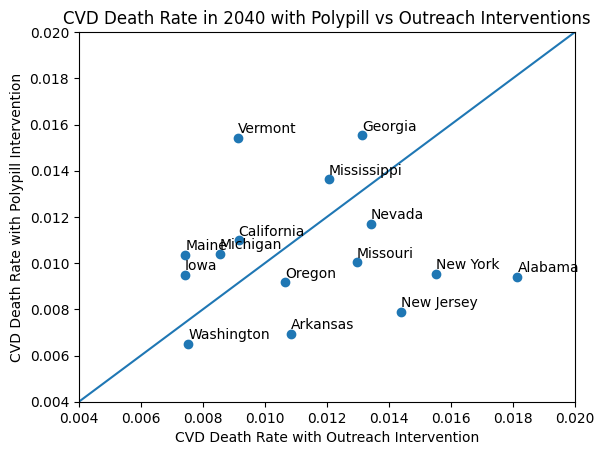

In [110]:
plt.scatter(outreach.iloc[:,0],polypill.iloc[:,1])

#plt.scatter(x=outreach.iloc[:,0], y=polypill.iloc[:,1], marker=r"$ {}".format(polypill.state),s=5000)

for i in range(len(outreach)):
    plt.annotate(polypill.iloc[i,0], (outreach.iloc[i,0], polypill.iloc[i,1] + 0.0002))
    
plt.xlabel('CVD Death Rate with Outreach Intervention')
plt.ylabel('CVD Death Rate with Polypill Intervention')
plt.ylim(0.004,0.02)
plt.xlim(0.004,0.02)
plt.plot([0, 0.2],[0, 0.2])
plt.title('CVD Death Rate in 2040 with Polypill vs Outreach Interventions')

In [111]:
## Make the same for other combos of interventions 

## Make the same but for % reduction from different interventions 

# First Time Incident Cases Averted

## Stroke Cases Averted

In [46]:
tran_stroke = tran.loc[tran.transition == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke']
tran_stroke = tran_stroke.groupby(['sex','input_draw','year','scenario']).value.sum().reset_index()

In [47]:
tran_baseline = tran_stroke.loc[tran_stroke.scenario == 'baseline']
tran_baseline = tran_baseline.rename(columns = {'value':'baseline'})
tran_stroke = tran_stroke.merge(tran_baseline[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
tran_stroke['averted_count'] = tran_stroke['baseline'] - tran_stroke['value']
tran_stroke['averted_percent'] = 100*((tran_stroke['baseline'] - tran_stroke['value'])/tran_stroke['baseline'])
tran_stroke.head()

sex  input_draw  year       scenario  value  baseline  averted_count  \
0  female          29  2023       baseline  508.0     508.0            0.0   
1  female          29  2023  lifestyle_100  507.0     508.0            1.0   
2  female          29  2023   lifestyle_50  507.0     508.0            1.0   
3  female          29  2023   outreach_100  503.0     508.0            5.0   
4  female          29  2023    outreach_50  507.0     508.0            1.0   

   averted_percent  
0         0.000000  
1         0.196850  
2         0.196850  
3         0.984252  
4         0.196850

In [48]:
stroke_summ_count = (tran_stroke
                      .groupby(['sex', 'year','scenario'])
                      .averted_count.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

stroke_summ_count.head()

sex  year       scenario  mean  2.5%  97.5%
0  female  2023       baseline   0.0   0.0  0.000
1  female  2023  lifestyle_100   0.4   0.0  1.000
2  female  2023   lifestyle_50   0.3   0.0  1.000
3  female  2023   outreach_100   3.1   1.0  4.775
4  female  2023    outreach_50   1.5   0.0  3.000

In [49]:
stroke_summ_percent = (tran_stroke
                      .groupby(['sex', 'year','scenario'])
                      .averted_percent.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

stroke_summ_percent.head()

sex  year       scenario      mean      2.5%     97.5%
0  female  2023       baseline  0.000000  0.000000  0.000000
1  female  2023  lifestyle_100  0.098765  0.000000  0.285262
2  female  2023   lifestyle_50  0.074784  0.000000  0.285262
3  female  2023   outreach_100  0.720108  0.280664  1.020426
4  female  2023    outreach_50  0.358621  0.000000  0.706981

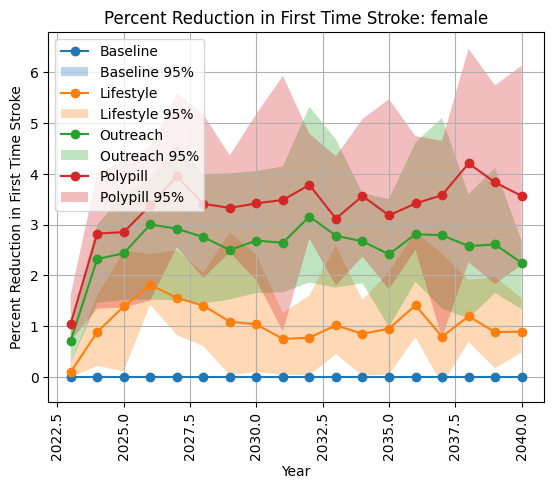

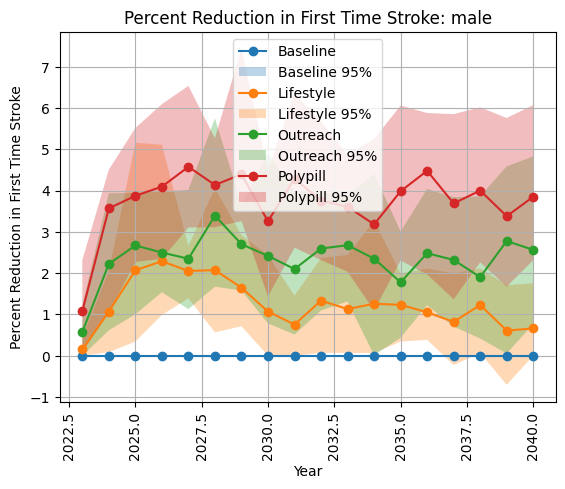

In [50]:
for sex in stroke_summ_percent.sex.unique(): 
    plt.figure()
    subdata = stroke_summ_percent.loc[(stroke_summ_percent.sex==sex) & (stroke_summ_percent.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = stroke_summ_percent.loc[(stroke_summ_percent.sex==sex) & (stroke_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = stroke_summ_percent.loc[(stroke_summ_percent.sex==sex) & (stroke_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = stroke_summ_percent.loc[(stroke_summ_percent.sex==sex) & (stroke_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in First Time Stroke: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in First Time Stroke')


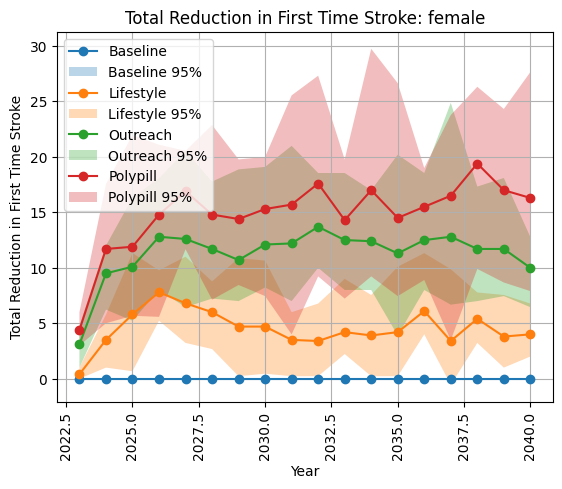

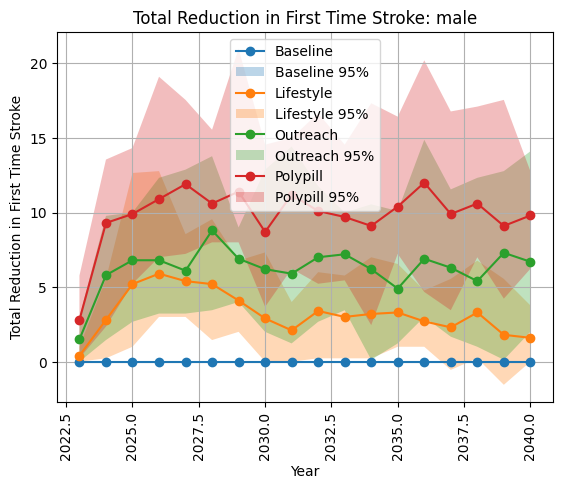

In [51]:
for sex in stroke_summ_count.sex.unique(): 
    plt.figure()
    subdata = stroke_summ_count.loc[(stroke_summ_count.sex==sex) & (stroke_summ_count.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = stroke_summ_count.loc[(stroke_summ_count.sex==sex) & (stroke_summ_count.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = stroke_summ_count.loc[(stroke_summ_count.sex==sex) & (stroke_summ_count.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = stroke_summ_count.loc[(stroke_summ_count.sex==sex) & (stroke_summ_count.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Total Reduction in First Time Stroke: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Total Reduction in First Time Stroke')


Note: again, not multiplied up to represent all of Alabama

## First Time Acute MI

In [52]:
tran_mi = tran.loc[tran.transition == 'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction']
tran_mi = tran_mi.groupby(['sex','input_draw','year','scenario']).value.sum().reset_index()

In [53]:
tran_baseline = tran_mi.loc[tran_mi.scenario == 'baseline']
tran_baseline = tran_baseline.rename(columns = {'value':'baseline'})
tran_mi = tran_mi.merge(tran_baseline[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
tran_mi['averted_count'] = tran_mi['baseline'] - tran_mi['value']
tran_mi['averted_percent'] = 100*((tran_mi['baseline'] - tran_mi['value'])/tran_mi['baseline'])
tran_mi.head()

sex  input_draw  year       scenario  value  baseline  averted_count  \
0  female          29  2023       baseline  497.0     497.0            0.0   
1  female          29  2023  lifestyle_100  497.0     497.0            0.0   
2  female          29  2023   lifestyle_50  497.0     497.0            0.0   
3  female          29  2023   outreach_100  494.0     497.0            3.0   
4  female          29  2023    outreach_50  496.0     497.0            1.0   

   averted_percent  
0         0.000000  
1         0.000000  
2         0.000000  
3         0.603622  
4         0.201207

In [54]:
mi_summ_count = (tran_mi
                      .groupby(['sex', 'year','scenario'])
                      .averted_count.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

mi_summ_count.head()

sex  year       scenario  mean  2.5%  97.5%
0  female  2023       baseline   0.0  0.00  0.000
1  female  2023  lifestyle_100   0.6  0.00  1.775
2  female  2023   lifestyle_50   0.2  0.00  1.000
3  female  2023   outreach_100   5.4  3.00  9.550
4  female  2023    outreach_50   2.9 -0.55  5.775

In [55]:
mi_summ_percent = (tran_mi
                      .groupby(['sex', 'year','scenario'])
                      .averted_percent.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

mi_summ_percent.head()

sex  year       scenario      mean      2.5%     97.5%
0  female  2023       baseline  0.000000  0.000000  0.000000
1  female  2023  lifestyle_100  0.106005  0.000000  0.302748
2  female  2023   lifestyle_50  0.028479  0.000000  0.153800
3  female  2023   outreach_100  0.945564  0.497773  1.498224
4  female  2023    outreach_50  0.496952 -0.122829  0.957328

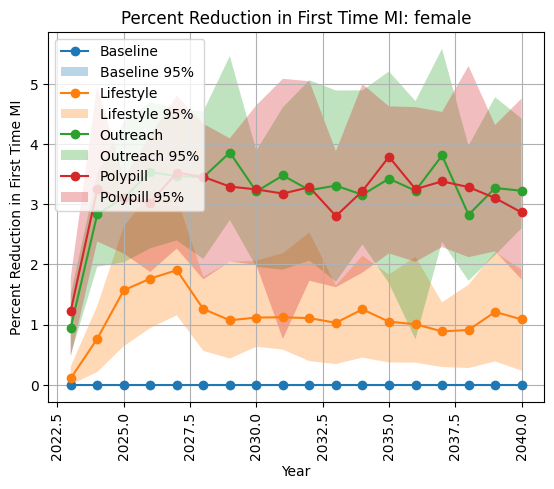

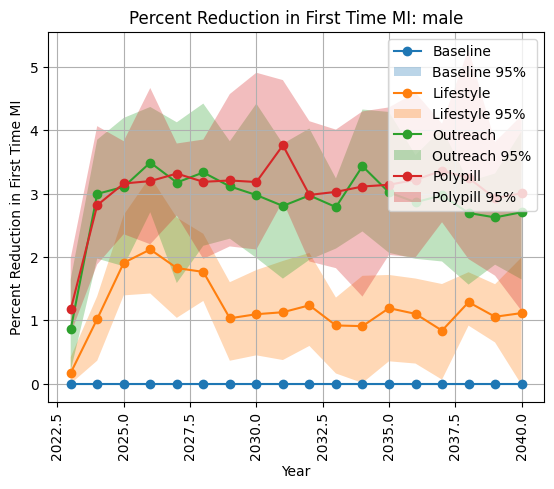

In [56]:
for sex in mi_summ_percent.sex.unique(): 
    plt.figure()
    subdata = mi_summ_percent.loc[(mi_summ_percent.sex==sex) & (mi_summ_percent.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = mi_summ_percent.loc[(mi_summ_percent.sex==sex) & (mi_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = mi_summ_percent.loc[(mi_summ_percent.sex==sex) & (mi_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = mi_summ_percent.loc[(mi_summ_percent.sex==sex) & (mi_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in First Time MI: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in First Time MI')


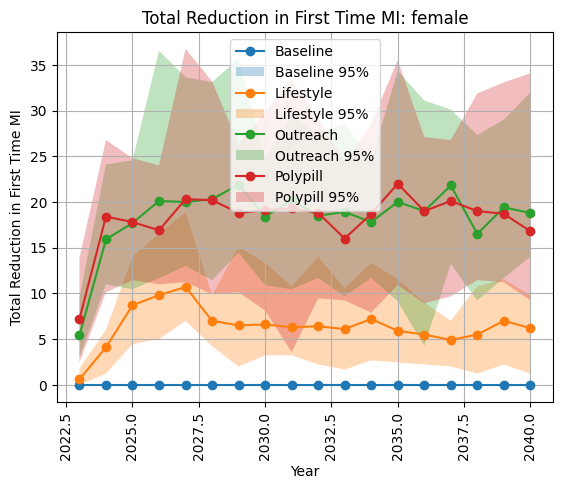

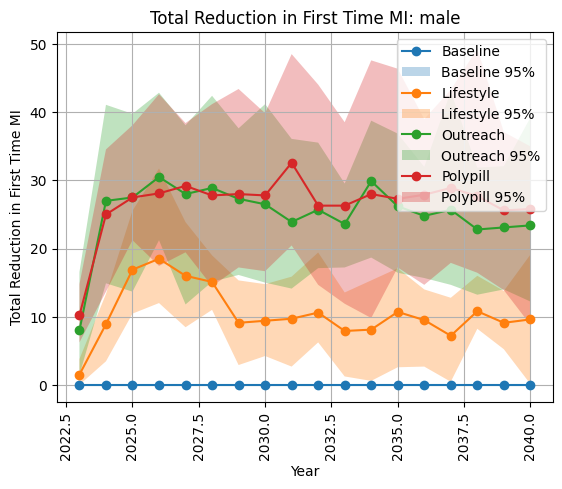

In [57]:
for sex in mi_summ_count.sex.unique(): 
    plt.figure()
    subdata = mi_summ_count.loc[(mi_summ_count.sex==sex) & (mi_summ_count.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = mi_summ_count.loc[(mi_summ_count.sex==sex) & (mi_summ_count.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = mi_summ_count.loc[(mi_summ_count.sex==sex) & (mi_summ_count.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = mi_summ_count.loc[(mi_summ_count.sex==sex) & (mi_summ_count.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Total Reduction in First Time MI: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Total Reduction in First Time MI')


## And First Time Heart Failure

In [58]:
tran_HF = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
tran_HF['age_bucket'] = np.where(np.isin(tran_HF['age'],['25_to_29','30_to_34','35_to_39','40_to_44']),'under_45',np.where(np.isin(tran_HF['age'],['45_to_49','50_to_54','55_to_59','60_to_64']),'45_to_65',np.where(np.isin(tran_HF['age'],['65_to_69','70_to_74','75_to_79','80_to_84']),'65_to_85','over_85')))
tran_HF_sex = tran_HF.groupby(['sex','input_draw','year','scenario']).value.sum().reset_index()
tran_HF_age = tran_HF.groupby(['sex','age','input_draw','year','scenario']).value.sum().reset_index()
tran_HF_age_bucket = tran_HF.groupby(['sex','age_bucket','input_draw','year','scenario']).value.sum().reset_index()
tran_HF_age_bucket.head()

sex age_bucket  input_draw  year       scenario  value
0  female   45_to_65          29  2023       baseline  380.0
1  female   45_to_65          29  2023  lifestyle_100  380.0
2  female   45_to_65          29  2023   lifestyle_50  380.0
3  female   45_to_65          29  2023   outreach_100  380.0
4  female   45_to_65          29  2023    outreach_50  380.0

In [53]:
person_time['age_bucket'] = np.where(np.isin(person_time['age'],['25_to_29','30_to_34','35_to_39','40_to_44']),'under_45',np.where(np.isin(person_time['age'],['45_to_49','50_to_54','55_to_59','60_to_64']),'45_to_65',np.where(np.isin(person_time['age'],['65_to_69','70_to_74','75_to_79','80_to_84']),'65_to_85','over_85')))
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['sex', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
per_time_age = person_time.groupby(['sex','age', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
per_time_age_bucket = person_time.groupby(['sex','age_bucket', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
per_time_age_bucket.head()

sex age_bucket  year  input_draw       scenario        ptvalue
0  female   45_to_65  2023          29       baseline  103131.071869
1  female   45_to_65  2023          29  lifestyle_100  103131.071869
2  female   45_to_65  2023          29   lifestyle_50  103131.071869
3  female   45_to_65  2023          29   outreach_100  103131.071869
4  female   45_to_65  2023          29    outreach_50  103131.071869

In [61]:
tran_HF_rate = tran_HF_age_bucket.merge(per_time_age_bucket[['sex','age_bucket', 'year', 'input_draw','scenario','ptvalue']], on=['sex', 'age_bucket','year', 'input_draw','scenario'])
tran_HF_rate['hf_rate'] = tran_HF_rate['value'] / tran_HF_rate['ptvalue']
tran_baseline = tran_HF_rate.loc[tran_HF_rate.scenario == 'baseline']
tran_baseline = tran_baseline.rename(columns = {'hf_rate':'baseline'})
tran_HF_rate = tran_HF_rate.merge(tran_baseline[['sex','age_bucket','input_draw','year','baseline']], on=['sex','age_bucket','input_draw','year']) 
tran_HF_rate['averted_count'] = tran_HF_rate['baseline'] - tran_HF_rate['hf_rate']
tran_HF_rate['averted_percent'] = 100*((tran_HF_rate['baseline'] - tran_HF_rate['hf_rate'])/tran_HF_rate['baseline'])
tran_HF_rate.head()

sex age_bucket  input_draw  year       scenario  value        ptvalue  \
0  female   45_to_65          29  2023       baseline  380.0  103131.071869   
1  female   45_to_65          29  2023  lifestyle_100  380.0  103131.071869   
2  female   45_to_65          29  2023   lifestyle_50  380.0  103131.071869   
3  female   45_to_65          29  2023   outreach_100  380.0  103131.071869   
4  female   45_to_65          29  2023    outreach_50  380.0  103131.071869   

    hf_rate  baseline  averted_count  averted_percent  
0  0.003685  0.003685            0.0              0.0  
1  0.003685  0.003685            0.0              0.0  
2  0.003685  0.003685            0.0              0.0  
3  0.003685  0.003685            0.0              0.0  
4  0.003685  0.003685            0.0              0.0

In [64]:
HF_summ_percent = (tran_HF_rate
                      .groupby(['sex','age_bucket', 'year','scenario'])
                      .averted_percent.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_summ_percent.head()

sex age_bucket  year       scenario      mean      2.5%     97.5%
0  female   45_to_65  2023       baseline  0.000000  0.000000  0.000000
1  female   45_to_65  2023  lifestyle_100  0.020504 -0.214681  0.252439
2  female   45_to_65  2023   lifestyle_50  0.030193 -0.170705  0.261473
3  female   45_to_65  2023   outreach_100  0.031738 -0.417743  0.603558
4  female   45_to_65  2023    outreach_50  0.100776  0.000000  0.656097

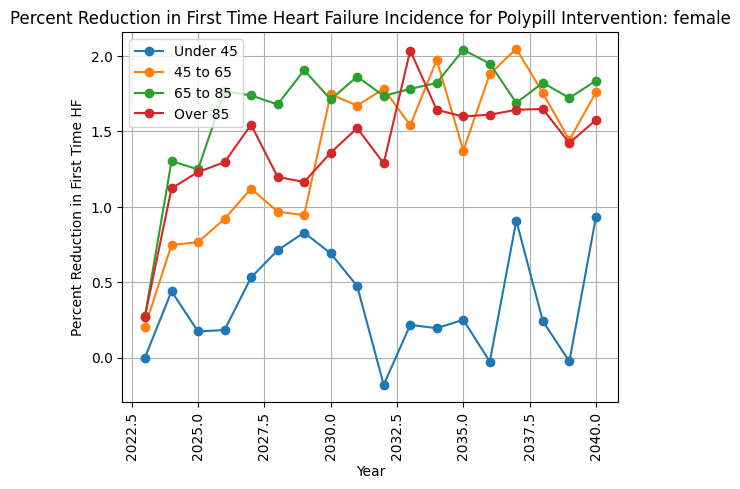

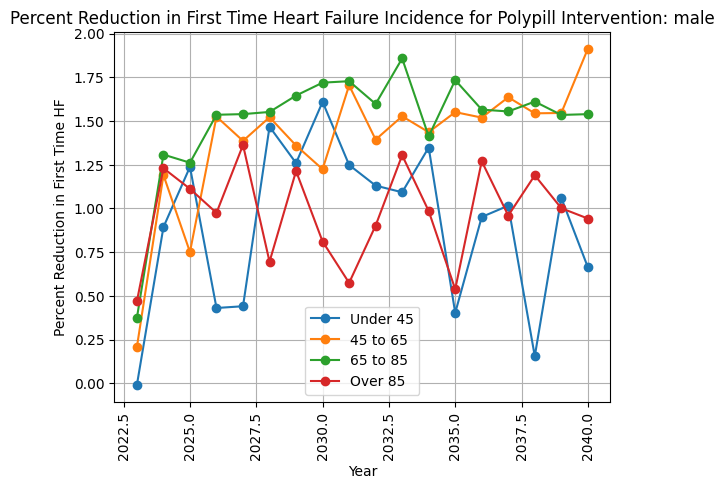

In [67]:
for sex in HF_summ_percent.sex.unique(): 
    plt.figure()
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='under_45') & (HF_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='45_to_65')  & (HF_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='65_to_85')  & (HF_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='over_85')  & (HF_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in First Time Heart Failure Incidence for Polypill Intervention: {sex}')
    plt.legend(['Under 45','45 to 65','65 to 85','Over 85'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in First Time HF')

## Percent Reduction in Heart Failure Prevalence

In [70]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
state_person_time_hf = state_person_time.loc[state_person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure','ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_heart_failure_residual'])].reset_index()
state_person_time_hf['age_bucket'] = np.where(np.isin(state_person_time_hf['age'],['25_to_29','30_to_34','35_to_39','40_to_44']),'under_45',np.where(np.isin(state_person_time_hf['age'],['45_to_49','50_to_54','55_to_59','60_to_64']),'45_to_65',np.where(np.isin(state_person_time_hf['age'],['65_to_69','70_to_74','75_to_79','80_to_84']),'65_to_85','over_85')))
hf_per_time_sex = state_person_time_hf.groupby(['sex', 'year', 'input_draw','scenario']).value.sum().reset_index()
hf_per_time_age = state_person_time_hf.groupby(['age','sex', 'year', 'input_draw','scenario']).value.sum().reset_index()
hf_per_time_age_bucket = state_person_time_hf.groupby(['age_bucket','sex', 'year', 'input_draw','scenario']).value.sum().reset_index()
hf_per_time_age_bucket.head()

age_bucket     sex  year  input_draw       scenario        value
0   45_to_65  female  2023          29       baseline  1159.403149
1   45_to_65  female  2023          29  lifestyle_100  1159.403149
2   45_to_65  female  2023          29   lifestyle_50  1159.403149
3   45_to_65  female  2023          29   outreach_100  1159.556468
4   45_to_65  female  2023          29    outreach_50  1159.556468

In [72]:
hf_prev_rate = hf_per_time_age_bucket.merge(per_time_age_bucket[['sex','age_bucket', 'year', 'input_draw','scenario','ptvalue']], on=['sex', 'age_bucket','year', 'input_draw','scenario'])
hf_prev_rate['hf_prev_rate'] = hf_prev_rate['value'] / hf_prev_rate['ptvalue']
hf_prev_baseline = hf_prev_rate.loc[hf_prev_rate.scenario == 'baseline']
hf_prev_baseline = hf_prev_baseline.rename(columns = {'hf_prev_rate':'baseline'})
hf_prev_rate = hf_prev_rate.merge(hf_prev_baseline[['sex','age_bucket','input_draw','year','baseline']], on=['sex','age_bucket','input_draw','year']) 
hf_prev_rate['averted_count'] = hf_prev_rate['baseline'] - hf_prev_rate['hf_prev_rate']
hf_prev_rate['averted_percent'] = 100*((hf_prev_rate['baseline'] - hf_prev_rate['hf_prev_rate'])/hf_prev_rate['baseline'])
hf_prev_rate.head()

age_bucket     sex  year  input_draw       scenario        value  \
0   45_to_65  female  2023          29       baseline  1159.403149   
1   45_to_65  female  2023          29  lifestyle_100  1159.403149   
2   45_to_65  female  2023          29   lifestyle_50  1159.403149   
3   45_to_65  female  2023          29   outreach_100  1159.556468   
4   45_to_65  female  2023          29    outreach_50  1159.556468   

         ptvalue  hf_prev_rate  baseline  averted_count  averted_percent  
0  103131.071869      0.011242  0.011242       0.000000         0.000000  
1  103131.071869      0.011242  0.011242       0.000000         0.000000  
2  103131.071869      0.011242  0.011242       0.000000         0.000000  
3  103131.071869      0.011244  0.011242      -0.000001        -0.013224  
4  103131.071869      0.011244  0.011242      -0.000001        -0.013224

In [73]:
HF_summ_percent = (hf_prev_rate
                      .groupby(['sex','age_bucket', 'year','scenario'])
                      .averted_percent.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_summ_percent.head()

sex age_bucket  year       scenario      mean      2.5%     97.5%
0  female   45_to_65  2023       baseline  0.000000  0.000000  0.000000
1  female   45_to_65  2023  lifestyle_100  0.002168 -0.014638  0.028039
2  female   45_to_65  2023   lifestyle_50 -0.001101 -0.013324  0.004791
3  female   45_to_65  2023   outreach_100  0.000274 -0.044735  0.034249
4  female   45_to_65  2023    outreach_50  0.005611 -0.010249  0.045866

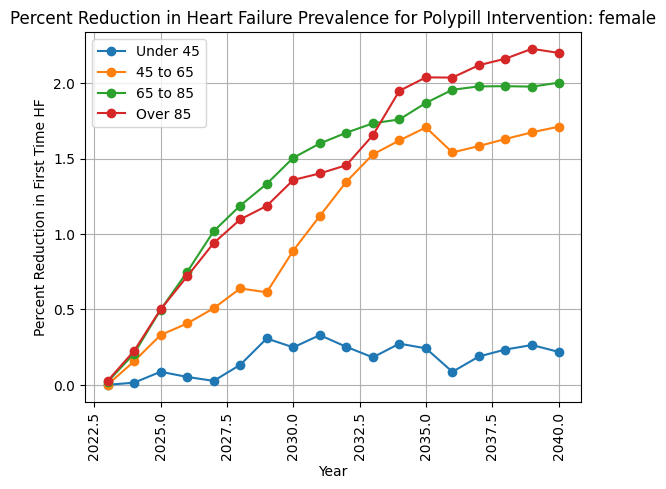

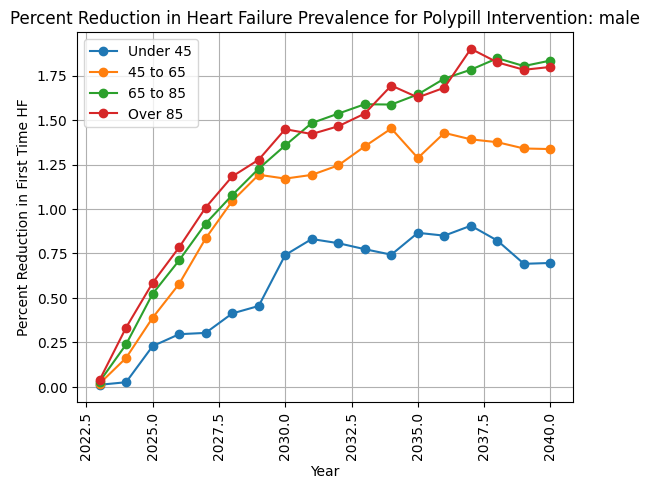

In [74]:
for sex in HF_summ_percent.sex.unique(): 
    plt.figure()
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='under_45') & (HF_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='45_to_65')  & (HF_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='65_to_85')  & (HF_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='over_85')  & (HF_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in Heart Failure Prevalence for Polypill Intervention: {sex}')
    plt.legend(['Under 45','45 to 65','65 to 85','Over 85'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in First Time HF')

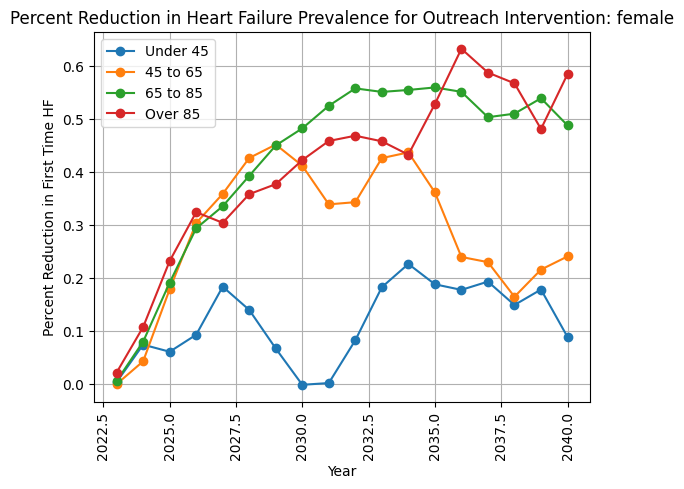

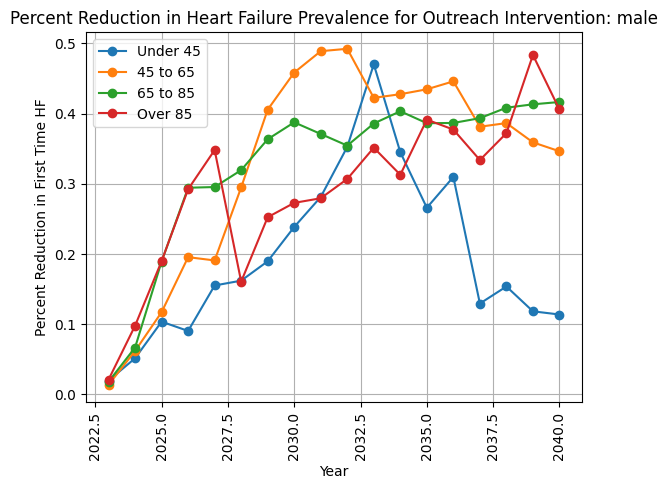

In [76]:
for sex in HF_summ_percent.sex.unique(): 
    plt.figure()
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='under_45') & (HF_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='45_to_65')  & (HF_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='65_to_85')  & (HF_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='over_85')  & (HF_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in Heart Failure Prevalence for Outreach Intervention: {sex}')
    plt.legend(['Under 45','45 to 65','65 to 85','Over 85'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in First Time HF')

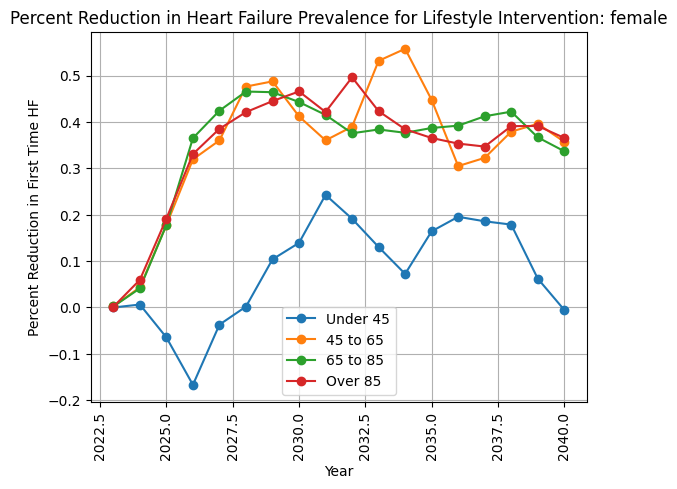

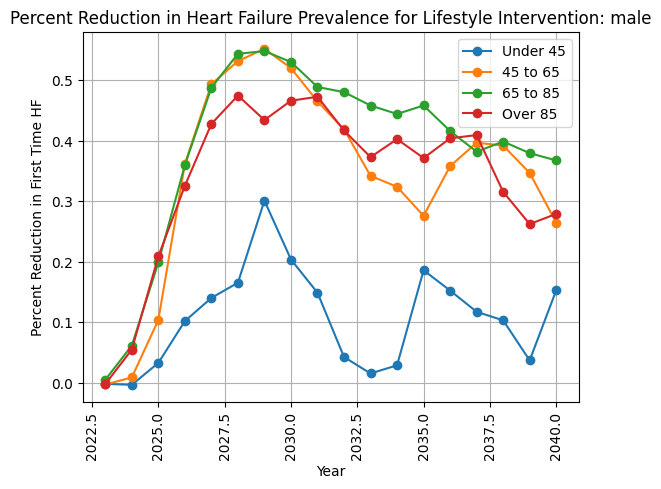

In [78]:
for sex in HF_summ_percent.sex.unique(): 
    plt.figure()
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='under_45') & (HF_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='45_to_65')  & (HF_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='65_to_85')  & (HF_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='over_85')  & (HF_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in Heart Failure Prevalence for Lifestyle Intervention: {sex}')
    plt.legend(['Under 45','45 to 65','65 to 85','Over 85'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in First Time HF')

## Testing Input Draws

### HF Prevalence Time Averted

In [116]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time_hf = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease"])].reset_index()
person_time_hf = person_time_hf.rename(columns = {'value':'ptvalue'})
per_time_group_hf = person_time_hf.groupby(['year', 'input_draw','scenario']).ptvalue.sum().reset_index()

In [117]:
hf_baseline = per_time_group_hf.loc[per_time_group_hf.scenario == 'baseline']
hf_baseline = hf_baseline.rename(columns = {'ptvalue':'baseline'})
HF_rate_prev = per_time_group_hf.merge(hf_baseline[['input_draw','year','baseline']], on=['input_draw','year']) 
HF_rate_prev['averted_count'] = HF_rate_prev['baseline'] - HF_rate_prev['ptvalue']
HF_rate_prev['averted_percent'] = 100*((HF_rate_prev['baseline'] - HF_rate_prev['ptvalue'])/HF_rate_prev['baseline'])
HF_rate_prev.head()

year  input_draw       scenario       ptvalue      baseline  averted_count  \
0  2023          29       baseline  16682.403833  16682.403833       0.000000   
1  2023          29  lifestyle_100  16681.637235  16682.403833       0.766598   
2  2023          29   lifestyle_50  16681.790554  16682.403833       0.613279   
3  2023          29   outreach_100  16680.640657  16682.403833       1.763176   
4  2023          29    outreach_50  16680.947296  16682.403833       1.456537   

   averted_percent  
0         0.000000  
1         0.004595  
2         0.003676  
3         0.010569  
4         0.008731

Text(0, 0.5, 'Percent Reduction in Prevalent HF')

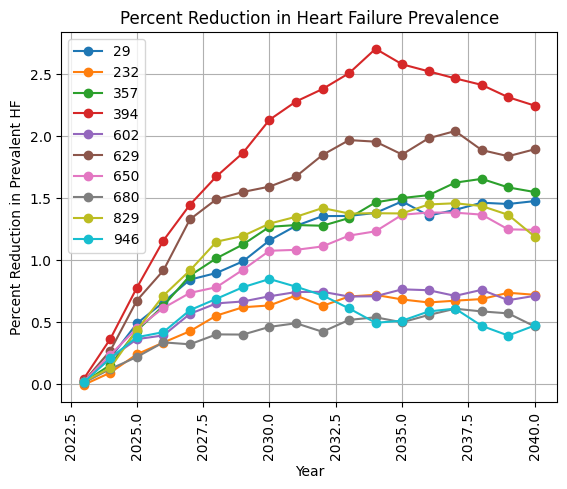

In [119]:
plt.figure()
for draw in HF_rate_prev.input_draw.unique(): 
    subdata = HF_rate_prev.loc[(HF_rate_prev.input_draw==draw) & (HF_rate_prev.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['averted_percent'], marker = 'o')
plt.title(f'Percent Reduction in Heart Failure Prevalence for Polypill')
plt.legend(HF_rate_prev.input_draw.unique())
plt.xticks(rotation=90) 
plt.grid()
plt.xlabel('Year')
plt.ylabel('Percent Reduction in Prevalent HF')

Text(0, 0.5, 'Percent Reduction in Prevalent HF')

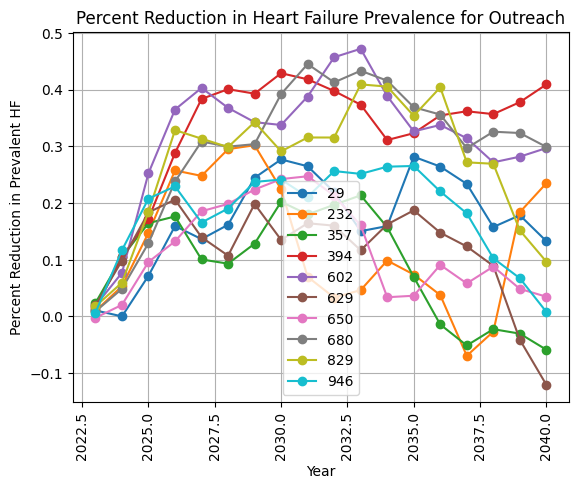

In [120]:
plt.figure()
for draw in HF_rate_prev.input_draw.unique(): 
    subdata = HF_rate_prev.loc[(HF_rate_prev.input_draw==draw) & (HF_rate_prev.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['averted_percent'], marker = 'o')
plt.title(f'Percent Reduction in Heart Failure Prevalence for Outreach')
plt.legend(HF_rate_prev.input_draw.unique())
plt.xticks(rotation=90) 
plt.grid()
plt.xlabel('Year')
plt.ylabel('Percent Reduction in Prevalent HF')

Text(0, 0.5, 'Percent Reduction in Prevalent HF')

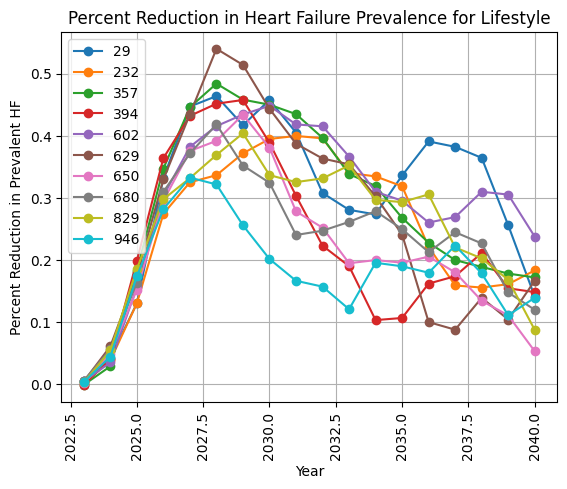

In [121]:
plt.figure()
for draw in HF_rate_prev.input_draw.unique(): 
    subdata = HF_rate_prev.loc[(HF_rate_prev.input_draw==draw) & (HF_rate_prev.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['averted_percent'], marker = 'o')
plt.title(f'Percent Reduction in Heart Failure Prevalence for Lifestyle')
plt.legend(HF_rate_prev.input_draw.unique())
plt.xticks(rotation=90) 
plt.grid()
plt.xlabel('Year')
plt.ylabel('Percent Reduction in Prevalent HF')

### DALYs Averted

In [15]:
daly_total_rate = daly_total.merge(per_time_age[['sex','input_draw','year','scenario','ptvalue']], on=['sex','input_draw','year','scenario'])
daly_total_rate['daly_rate'] = daly_total_rate['daly'] / daly_total_rate['ptvalue']
daly_total_rate.head()

sex  input_draw  year       scenario          daly        ptvalue  \
0  female          29  2023       baseline  84207.339166  259725.086927   
1  female          29  2023  lifestyle_100  84207.242173  259725.086927   
2  female          29  2023   lifestyle_50  84207.242173  259725.086927   
3  female          29  2023   outreach_100  84193.488580  259725.240246   
4  female          29  2023    outreach_50  84193.639013  259725.240246   

   daly_rate  
0   0.324217  
1   0.324217  
2   0.324217  
3   0.324164  
4   0.324164

In [16]:
daly_total_baseline = daly_total_rate.loc[daly_total_rate.scenario == 'baseline']
daly_total_baseline = daly_total_baseline.rename(columns = {'daly_rate':'baseline'})
daly_total_rate = daly_total_rate.merge(daly_total_baseline[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
daly_total_rate['averted_count'] = daly_total_rate['daly_rate'] - daly_total_rate['baseline']
daly_total_rate['averted_percent'] = 100*((daly_total_rate['daly_rate'] - daly_total_rate['baseline'])/daly_total_rate['baseline'])
daly_total_rate.head()

sex  input_draw  year       scenario          daly        ptvalue  \
0  female          29  2023       baseline  84207.339166  259725.086927   
1  female          29  2023  lifestyle_100  84207.242173  259725.086927   
2  female          29  2023   lifestyle_50  84207.242173  259725.086927   
3  female          29  2023   outreach_100  84193.488580  259725.240246   
4  female          29  2023    outreach_50  84193.639013  259725.240246   

   daly_rate  baseline  averted_count  averted_percent  
0   0.324217  0.324217   0.000000e+00         0.000000  
1   0.324217  0.324217  -3.734475e-07        -0.000115  
2   0.324217  0.324217  -3.734475e-07        -0.000115  
3   0.324164  0.324217  -5.351923e-05        -0.016507  
4   0.324164  0.324217  -5.294003e-05        -0.016329

Text(0, 0.5, 'Percent Reduction in DALYs')

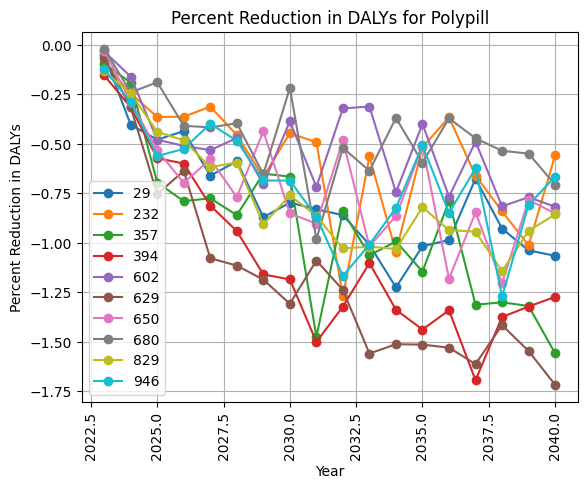

In [20]:
plt.figure()
for draw in daly_total_rate.input_draw.unique(): 
    subdata = daly_total_rate.loc[(daly_total_rate.input_draw==draw) & (daly_total_rate.sex=='male') & (daly_total_rate.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['averted_percent'], marker = 'o')
plt.title(f'Percent Reduction in DALYs for Polypill')
plt.legend(daly_total_rate.input_draw.unique())
plt.xticks(rotation=90) 
plt.grid()
plt.xlabel('Year')
plt.ylabel('Percent Reduction in DALYs')

Text(0, 0.5, 'Percent Reduction in DALYs')

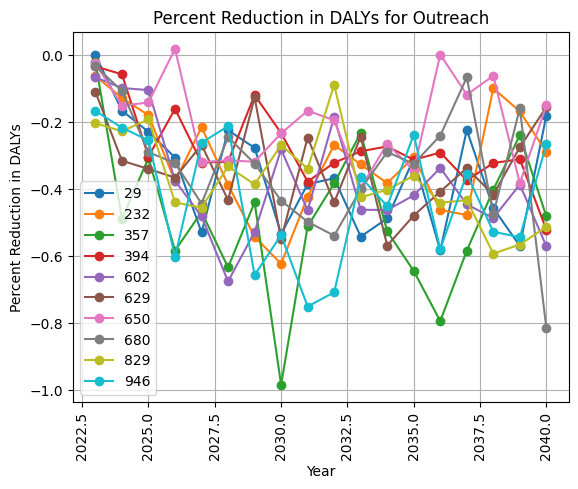

In [21]:
plt.figure()
for draw in daly_total_rate.input_draw.unique(): 
    subdata = daly_total_rate.loc[(daly_total_rate.input_draw==draw) & (daly_total_rate.sex=='male') & (daly_total_rate.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['averted_percent'], marker = 'o')
plt.title(f'Percent Reduction in DALYs for Outreach')
plt.legend(daly_total_rate.input_draw.unique())
plt.xticks(rotation=90) 
plt.grid()
plt.xlabel('Year')
plt.ylabel('Percent Reduction in DALYs')

Text(0, 0.5, 'Percent Reduction in DALYs')

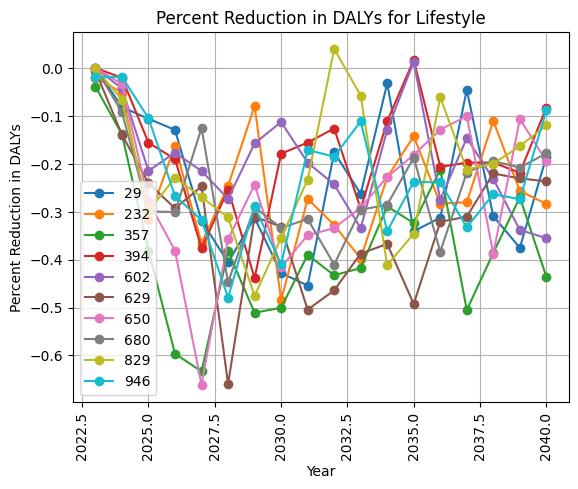

In [22]:
plt.figure()
for draw in daly_total_rate.input_draw.unique(): 
    subdata = daly_total_rate.loc[(daly_total_rate.input_draw==draw) & (daly_total_rate.sex=='male') & (daly_total_rate.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['averted_percent'], marker = 'o')
plt.title(f'Percent Reduction in DALYs for Lifestyle')
plt.legend(daly_total_rate.input_draw.unique())
plt.xticks(rotation=90) 
plt.grid()
plt.xlabel('Year')
plt.ylabel('Percent Reduction in DALYs')

## Risk Exposures

In [89]:
risks = pd.read_csv(sim_results_dir + 'risk_exposure_time.csv')
risks.head()

Unnamed: 0     sex  year                            risk  \
0           0  female  2023  high_body_mass_index_in_adults   
1           1  female  2023  high_body_mass_index_in_adults   
2           2  female  2023  high_body_mass_index_in_adults   
3           3  female  2023  high_body_mass_index_in_adults   
4           4  female  2023  high_body_mass_index_in_adults   

              measure  input_draw       scenario       age          value  
0  risk_exposure_time          29       baseline  25_to_29  835692.780297  
1  risk_exposure_time          29  lifestyle_100  25_to_29  835692.780297  
2  risk_exposure_time          29   lifestyle_50  25_to_29  835692.780297  
3  risk_exposure_time          29   outreach_100  25_to_29  835692.780297  
4  risk_exposure_time          29    outreach_50  25_to_29  835692.780297

In [86]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time = person_time.groupby(['sex', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
per_time_age = person_time.groupby(['sex','age', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
per_time_age.head()

sex       age  year  input_draw       scenario      ptvalue
0  female  25_to_29  2023          29       baseline  27022.28063
1  female  25_to_29  2023          29  lifestyle_100  27022.28063
2  female  25_to_29  2023          29   lifestyle_50  27022.28063
3  female  25_to_29  2023          29   outreach_100  27022.28063
4  female  25_to_29  2023          29    outreach_50  27022.28063

In [95]:
risk_exp = risks.merge(per_time_age[['sex','age','input_draw','year','scenario','ptvalue']], on=['sex','age','input_draw','year','scenario'])
risk_exp['risk_exp'] = risk_exp['value'] / risk_exp['ptvalue']
risk_exp.head()

Unnamed: 0     sex  year                            risk  \
0           0  female  2023  high_body_mass_index_in_adults   
1        1050  female  2023     high_fasting_plasma_glucose   
2        2100  female  2023            high_ldl_cholesterol   
3        3150  female  2023    high_systolic_blood_pressure   
4           1  female  2023  high_body_mass_index_in_adults   

              measure  input_draw       scenario       age         value  \
0  risk_exposure_time          29       baseline  25_to_29  8.356928e+05   
1  risk_exposure_time          29       baseline  25_to_29  1.320725e+05   
2  risk_exposure_time          29       baseline  25_to_29  7.654238e+04   
3  risk_exposure_time          29       baseline  25_to_29  2.911479e+06   
4  risk_exposure_time          29  lifestyle_100  25_to_29  8.356928e+05   

       ptvalue    risk_exp  
0  27022.28063   30.926064  
1  27022.28063    4.887540  
2  27022.28063    2.832565  
3  27022.28063  107.743658  
4  27022.28063   30.926064

In [96]:
risk_exp = (risk_exp
                      .groupby(['sex','age', 'year','scenario','risk'])
                      .risk_exp.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

risk_exp.head()

sex       age  year       scenario                            risk  \
0  female  25_to_29  2023       baseline  high_body_mass_index_in_adults   
1  female  25_to_29  2023       baseline     high_fasting_plasma_glucose   
2  female  25_to_29  2023       baseline            high_ldl_cholesterol   
3  female  25_to_29  2023       baseline    high_systolic_blood_pressure   
4  female  25_to_29  2023  lifestyle_100  high_body_mass_index_in_adults   

         mean        2.5%       97.5%  
0   30.715274   30.390470   31.006332  
1    5.341261    4.846877    6.187954  
2    2.634736    2.558028    2.799935  
3  110.017126  107.879221  112.581477  
4   30.715274   30.390470   31.006332

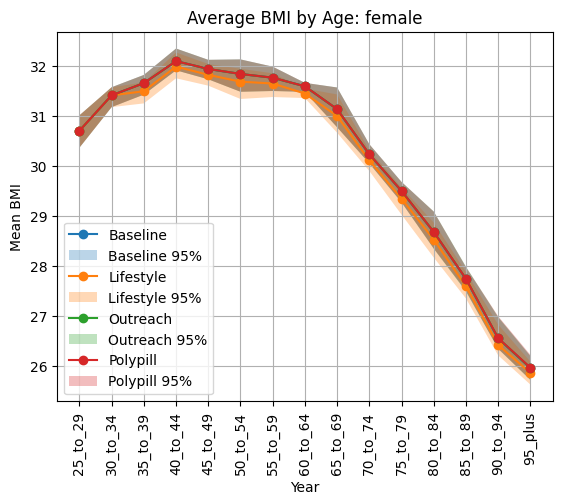

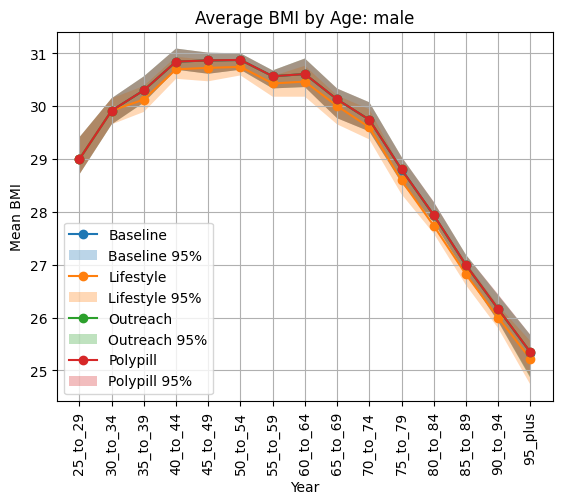

In [105]:
for sex in risk_exp.sex.unique(): 
    plt.figure()
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_body_mass_index_in_adults') & (risk_exp.scenario=='baseline') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_body_mass_index_in_adults') & (risk_exp.scenario=='lifestyle_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_body_mass_index_in_adults') & (risk_exp.scenario=='outreach_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_body_mass_index_in_adults') & (risk_exp.scenario=='polypill_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Average BMI by Age: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Mean BMI')

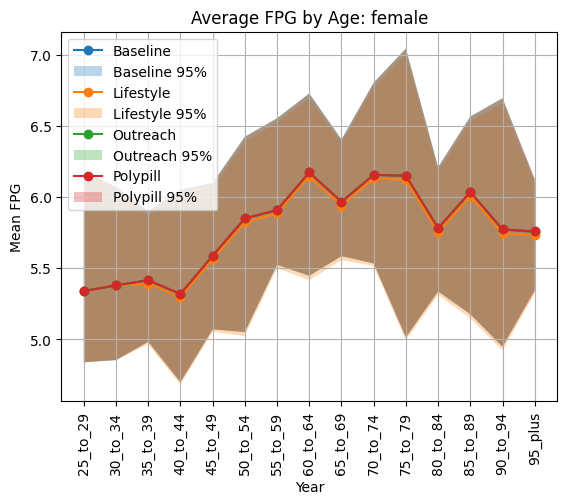

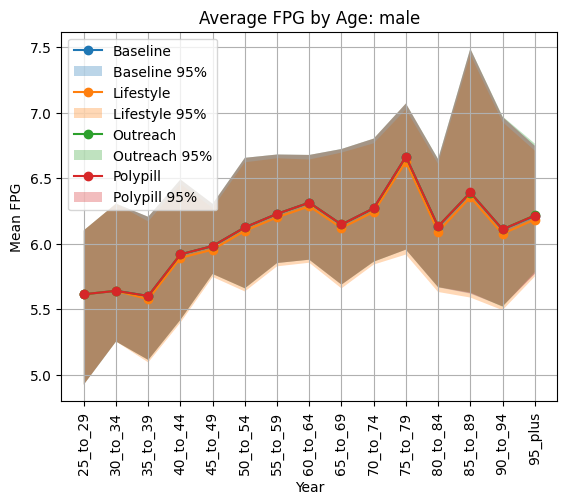

In [107]:
for sex in risk_exp.sex.unique(): 
    plt.figure()
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_fasting_plasma_glucose') & (risk_exp.scenario=='baseline') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_fasting_plasma_glucose') & (risk_exp.scenario=='lifestyle_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_fasting_plasma_glucose') & (risk_exp.scenario=='outreach_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_fasting_plasma_glucose') & (risk_exp.scenario=='polypill_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Average FPG by Age: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Mean FPG')

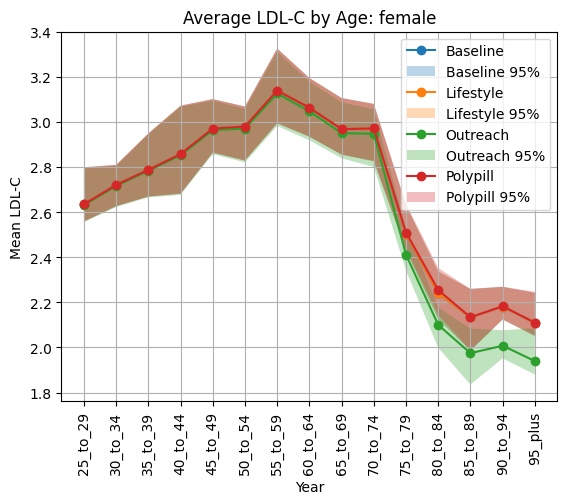

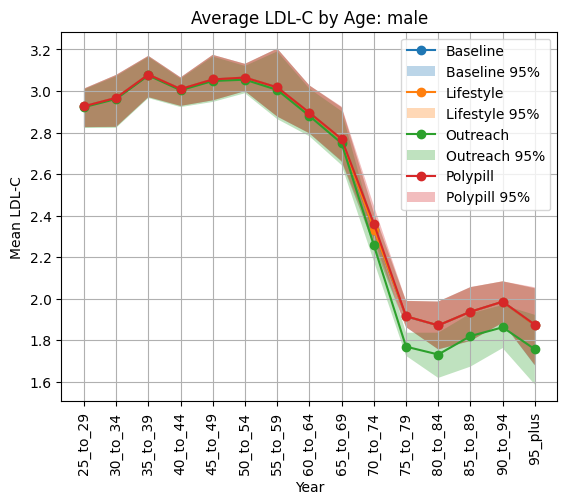

In [108]:
for sex in risk_exp.sex.unique(): 
    plt.figure()
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_ldl_cholesterol') & (risk_exp.scenario=='baseline') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_ldl_cholesterol') & (risk_exp.scenario=='lifestyle_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_ldl_cholesterol') & (risk_exp.scenario=='outreach_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_ldl_cholesterol') & (risk_exp.scenario=='polypill_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Average LDL-C by Age: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Mean LDL-C')

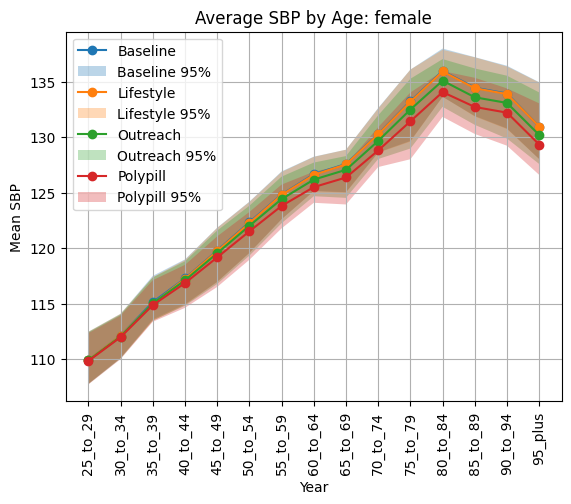

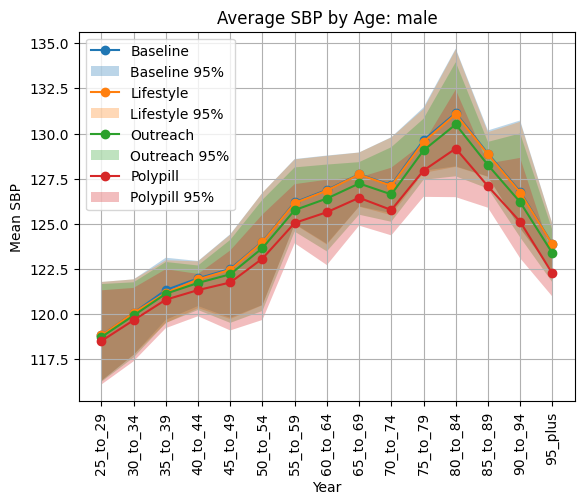

In [109]:
for sex in risk_exp.sex.unique(): 
    plt.figure()
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_systolic_blood_pressure') & (risk_exp.scenario=='baseline') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_systolic_blood_pressure') & (risk_exp.scenario=='lifestyle_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_systolic_blood_pressure') & (risk_exp.scenario=='outreach_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_systolic_blood_pressure') & (risk_exp.scenario=='polypill_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Average SBP by Age: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Mean SBP')